<a href="https://colab.research.google.com/github/ish66726-a11y/colab-notebooks/blob/main/notebooks/11Vasicek%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#11 Vasicek（ワセチェック）モデル

##11-1 Vasicek（ワセチェック）モデルを使った債券価格の算出  


### 1. ゼロクーポン債の基本

額面を $X$、満期を $T$ とすると、**金利が一定** の場合の現在価値は

$$
P(0,T) = X e^{-rT}
$$

例：  
- 額面 X = 1000
- 金利 r = 0.10
- 満期 T = 2  

なら

$$
P(0,2)=1000 e^{-0.1\times 2}
$$

---
###2. Vasicek モデル（金利の確率微分方程式）
金利 $r_t$ は実際には **常に変動する**。

そこで金利に対して **Vasicek モデル**を使う。
$$
dr_t = \kappa(\theta - r_t)\,dt + \sigma\, dW_t
$$

ここで：

| 変数 | 意味 |
|------|------|
| $\kappa$ | 平均回帰速度（Mean reversion speed） |
| $\theta$ | 長期平均金利 |
| $\sigma$ | ボラティリティ |
| $W_t$ | Wiener 過程（標準ブラウン運動） |

**重要点：**

- 金利は **平均 $\theta$ に戻ろうとする**
- その強さが $\kappa$
- ノイズ（不確実性）の大きさが $\sigma$

---

###3. 金利が確率的に変動する場合の債券価格

本来の現在価値は

$$
P(0,T) = \mathbb{E}\left[ e^{-\int_0^T r_t\, dt} \right]
$$

ただし積分は金利パス $r_t$ に依存する。  
解析的に厳しいので **Monte Carlo 法**を使う。

---

###4. Monte Carlo 法による債券価格の考え方

1. **Vasicek SDE を用いて金利パスを多数生成する**
   - $r_t^{(1)}, r_t^{(2)}, \dots , r_t^{(N)}$

2. 各パスで割引因子を計算する：

$$
D^{(i)} = e^{- \int_0^T r_t^{(i)} dt }
$$

3. その平均を取る：

$$
P(0,T) = X \cdot \frac{1}{N} \sum_{i=1}^N D^{(i)}
$$

---

###5. なぜ Monte Carlo を使うのか？

- 金利がランダムなので解析的に解くのが困難
- Vasicek は SDE（確率微分方程式）なので数値解が必要
- Monte Carlo は複雑なモデルでも扱える
- シミュレーション回数を増やすと精度が上がる




##11-2 Vasicek（ワセチェック）モデルを用いた債券価格の Monte Carlo 実装  

---

### 1. モデルの目的

- 金利 $r_t$ は変動するため、将来の金利パスを多数生成し、債券価格を計算する必要がある
- Vasicek モデルを用いて金利プロセスをシミュレーションし、生成した金利パスを使って、ゼロクーポン債の割引現在価値を求める

---

### 2. シミュレーション設定

- シミュレーション回数：$N_\text{sim} = 1000$  
- 1パスあたりの金利点数：$N_\text{points} = 200$  
- 各パスは Vasicek モデルで生成  
- 完成形データは「1000 × 201」の行列（最初の時点を含むため）

---

## 3. Vasicek モデルの離散化式

Vasicek の連続 SDE：

$$
dr_t = \kappa(\theta - r_t)\,dt + \sigma\, dW_t
$$

これを時間刻み $\Delta t$ で離散化すると：

$$
\Delta r_t = \kappa(\theta - r_t)\Delta t + \sigma \sqrt{\Delta t} \; Z
$$

ここで $Z \sim N(0,1)$

---

## 4. Bond Pricing Monte Carlo の流れ

1. 初期金利 $r_0$ をセット  
2. Vasicek モデルで金利パスを $N_\text{sim}$ 回生成  
3. 各パスについて割引因子を計算  
4. 平均して現在価値を得る

---

## 5. Pythonコード（ワセチェック金利シミュレーション）







      0         1         2         3         4         5         6    \
0    0.01  0.009001  0.008197  0.008077  0.009811  0.008649  0.008925   
1    0.01  0.007995  0.009811  0.008258  0.008721  0.009129  0.008843   
2    0.01  0.009490  0.009450  0.006511  0.006270  0.004702  0.004237   
3    0.01  0.009188  0.007644  0.007971  0.008961  0.007993  0.008625   
4    0.01  0.008520  0.008640  0.008265  0.007465  0.005849  0.007086   
..    ...       ...       ...       ...       ...       ...       ...   
995  0.01  0.009385  0.012409  0.011492  0.010087  0.010502  0.009674   
996  0.01  0.009219  0.010768  0.011893  0.011321  0.010218  0.010081   
997  0.01  0.011313  0.011280  0.011929  0.011217  0.012912  0.011488   
998  0.01  0.009629  0.009635  0.007453  0.006391  0.006542  0.007125   
999  0.01  0.012503  0.013814  0.013114  0.014674  0.014557  0.014554   

          7         8         9    ...       191       192       193  \
0    0.007471  0.006526  0.007877  ...  0.033840  0

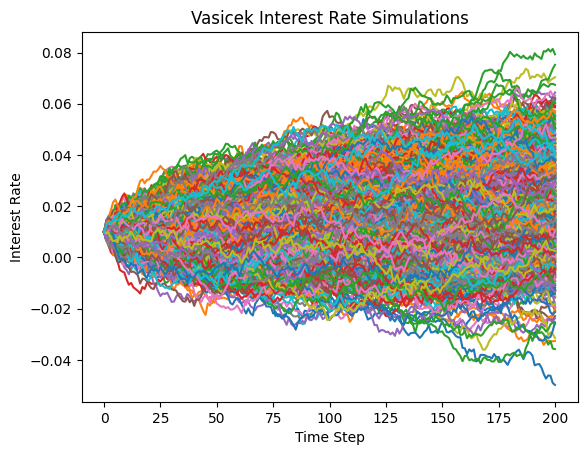

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- シミュレーション設定 ---
N_simulations = 1000      # 金利パスの数
N_points = 200            # 1パスあたりの時点数


# --- Bond Pricing Monte Carlo 関数 ---
def vasicek_monte_carlo(X, r0, kappa, theta, sigma, T=1.0):
    """
    X     : 債券の額面（例：1000）
    r0    : 初期金利
    kappa : 平均回帰速度
    theta : 長期平均金利
    sigma : ボラティリティ
    T     : 満期（年）
    """

    dt = T / float(N_points)
    results = []

    # --- 金利パスを N_simulations 本生成 ---
    for _ in range(N_simulations):
        rates = [r0]

        for _ in range(N_points):
            dr = kappa * (theta - rates[-1]) * dt \
                 + sigma * np.sqrt(dt) * np.random.normal()
            rates.append(rates[-1] + dr)

        results.append(rates)

    return results
if __name__ == "__main__":
    # パラメータ（例）
    X = 1000       # 額面
    r0 = 0.01      # 初期金利
    kappa = 0.3
    theta = 0.05
    sigma = 0.02

    # Monte Carlo 実行
    result = vasicek_monte_carlo(X, r0, kappa, theta, sigma)

    # pandas DataFrame に変換
    df = pd.DataFrame(result)
    print(df)

    # プロットのために転置
    df_T = df.T

    # プロット
    df_T.plot(legend=False)
    plt.title("Vasicek Interest Rate Simulations")
    plt.xlabel("Time Step")
    plt.ylabel("Interest Rate")
    plt.show()

---

### 7. 出力されるシミュレーションのイメージ

- 行：金利パス（シミュレーション番号）
- 列：時間ステップ
- 転置後（プロット用）：
  - 縦：金利
  - 横：時間

複数の金利パスが広がりながら **平均 $\theta$ の周りに回帰する様子** が見える。

##11-3 Vasicek（ワセチェック）モデルによる債券価格の計算（続編）

前回は Vasicek モデルを使って **未来の金利パスを大量生成する** ところまでを実装しました。  
今回はこの続きとして：

1. 生成した金利パスを用いて  
2. **ゼロクーポン債の価格を Monte Carlo により算出する**  

という部分をまとめます。

---

### 1. 生成した金利パスを使って何をするのか？

ゼロクーポン債の価格は、以下のように **割引因子の積分** を用いて表される：

$$
P(0,T) = X \cdot \mathbb{E}\left[\exp\left(-\int_0^T r_t\, dt\right)\right]
$$

ここで：

- $X$：額面（例：1000ドル）
- $r_t$：Vasicek モデルで生成した金利パス
- $\int_0^T r_t dt$：金利の積分（面積）

積分は矩形近似(リーマン和)で計算する：

$$
\int_0^T r_t dt \approx \sum_{i=0}^{N-1} r_i \, \Delta t
$$

---

### 2. 債券価格に必要なステップ

1. Vasicek モデルで金利パスを多数生成  
2. 각金利パスごとに  
   $$
   I = \sum r_i \Delta t
   $$
   を計算  
3. さらに  
   $$
   e^{-I}
   $$
   を計算  
4. 全シミュレーションで平均し  
   $$
   P(0,T) = X \cdot \text{mean}(e^{-I})
   $$
   を求める

---

### 3. Pythonコード（Vasicek シミュレーション＋債券価格計算）






    0         1         2         3         4         5         6         7    \
0  0.05  0.049649  0.050363  0.051291  0.049116  0.047199  0.047675  0.046993   
1  0.05  0.047423  0.046836  0.050010  0.051924  0.051206  0.050778  0.051349   
2  0.05  0.049839  0.047975  0.050642  0.050801  0.049795  0.050190  0.050923   
3  0.05  0.052685  0.052370  0.052426  0.054614  0.056454  0.058278  0.058896   
4  0.05  0.048005  0.047388  0.048671  0.046826  0.046815  0.049044  0.049935   

        8         9    ...       191       192       193       194       195  \
0  0.048078  0.045874  ...  0.051767  0.051001  0.051496  0.049726  0.048281   
1  0.055397  0.056997  ...  0.071876  0.073489  0.073767  0.071826  0.072499   
2  0.050164  0.051023  ...  0.063701  0.064485  0.064504  0.063883  0.063737   
3  0.059989  0.057628  ...  0.068231  0.069587  0.071276  0.071606  0.068934   
4  0.051791  0.053234  ...  0.094453  0.094666  0.094314  0.094774  0.095363   

        196       197       198 

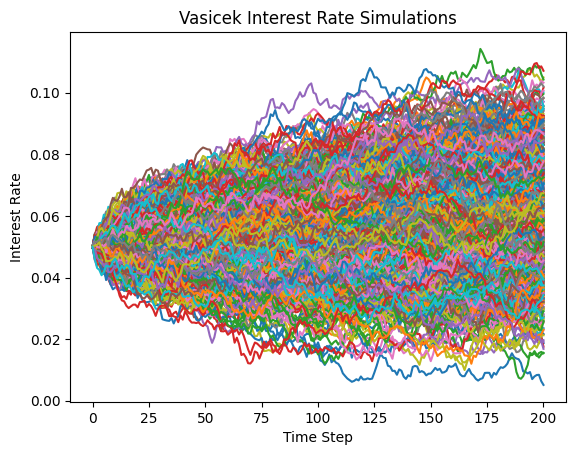

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- シミュレーション設定 ---
N_simulations = 1000     # 金利パス数
N_points = 200           # 金利パスの点数


def vasicek_monte_carlo(X, r0, kappa, theta, sigma, T=1.0):
    """
    X     : 債券の額面
    r0    : 初期金利
    kappa : 平均回帰速度
    theta : 長期平均
    sigma : ボラティリティ
    T     : 満期（年）
    """
    dt = T / float(N_points)
    results = []

    # --- 金利パスを多数生成 ---
    for _ in range(N_simulations):
        rates = [r0]

        for _ in range(N_points):
            dr = kappa * (theta - rates[-1]) * dt \
                 + sigma * np.sqrt(dt) * np.random.normal()
            rates.append(rates[-1] + dr)

        results.append(rates)

    return np.array(results)  # shape: (N_sim, N_points+1)


if __name__ == "__main__":
    # パラメータ例
    X = 1000
    r0 = 0.05
    kappa = 0.3
    theta = 0.09
    sigma = 0.02
    T = 1.0

    # --- 金利シミュレーション ---
    rates = vasicek_monte_carlo(X, r0, kappa, theta, sigma, T)

    # DataFrame に変換（任意）
    df = pd.DataFrame(rates)
    print(df.head())

    # --- 債券価格の計算 ---
    dt = T / float(N_points)

    # 積分（リーマン和）
    integral_sum = rates.sum(axis=1) * dt

    # 割引因子の計算
    discount_factors = np.exp(-integral_sum)

    # 平均を取る（Monte Carlo）
    bond_price = X * np.mean(discount_factors)

    print(f"Bond Price (Monte Carlo): ${bond_price:,.2f}")

    # --- プロット ---
    df.T.plot(legend=False)
    plt.title("Vasicek Interest Rate Simulations")
    plt.xlabel("Time Step")
    plt.ylabel("Interest Rate")
    plt.show()

---
### 4. 計算結果の例

- 初期金利が高い → 割引が強くなる → **債券価格は低い**  
- 初期金利が低い → 割引が弱い → **債券価格は高い**

例：

| r0 | theta | Bond Price |
|----|--------|-------------|
| 0.10 | 0.09 | 約 \$570 |
| 0.01 | 0.03 | 約 \$880 |

---

### 5. まとめ

- Vasicek モデルは **平均回帰**する金利を表現できるため債券価格モデルに適している  
- Monte Carlo により  
  $$
  \mathbb{E}[e^{-\int r_t dt}]
  $$
  を直接推定できる  
- 実装は比較的シンプルで、拡張もしやすい
